Run this line to install `RobustiPy` from GitHub.

In [ ]:
%pip install git+https://github.com/robustipy/robustipy.git

In [1]:
import os
import numpy as np
from robustipy.models import LRobust
import pandas as pd
import matplotlib.pyplot as plt

# Data generation
Let's generated some data based on some covariance values and totally made-up coeficients.

This time, the `y` variable is binary.

In [2]:
# Define beta coefficients
beta1 = np.array([.2, .5, -.4, -.1, .2])
beta2 = np.array([.3, .4, -.35, -.7, .2])
beta3 = np.array([.15, .6, -.45, -.9, .2])
beta4 = np.array([.4, .3, -.5, -.1, .2]) 

# Define covariance matrix
cov_matrix = np.array([[1, 0.7, 0.5, 0.7, 0.1],
                       [0.7, 1, 0.5, 0.3, 0.2],
                       [0.5, 0.5, 1, 0.4, 0.2],
                       [0.7, 0.3, 0.4, 1, 0.6],
                       [0.1, 0.2, 0.2, 0.6, 1]])

Now let's define the final sample size of our generated dataset. We will start with 1000, but we can change this to any number.

In [3]:
num_samples = 1000

We now can create a synthetic dataset with fake data that has the relationships that we want to test.

In [4]:
mean_vector = np.zeros(5)
X = np.random.multivariate_normal(mean=mean_vector, cov=cov_matrix, size=num_samples)
X_i = np.column_stack((np.ones(num_samples), X[:, 0:4]))
errors = np.random.normal(loc=0.0, scale=1.0, size=num_samples)

# Calculate dependent variable Y1
Y1 = np.dot(X_i, beta1) + errors

# Convert Y1 to binary
threshold = np.median(Y1)
Y1_binary = (Y1 > threshold).astype(int)
np_data = np.column_stack((Y1_binary, X))
data = pd.DataFrame(np_data, columns=['y1', 'x1', 'z1', 'z2', 'z3', 'z4'])
data.head()

,y1,x1,z1,z2,z3,z4
0,0.0,-1.651433,-0.170860,0.485454,-1.546125,-0.525796
1,1.0,0.892897,-0.099357,-0.268692,0.647601,-0.583546
2,1.0,-1.688853,-0.537064,-0.439879,-1.307419,-0.344048
3,1.0,0.900936,1.254443,0.926049,1.426079,2.231584
4,0.0,-1.248808,-0.703647,-0.737591,0.140083,1.940337


Let's plot the correlation of our variables.

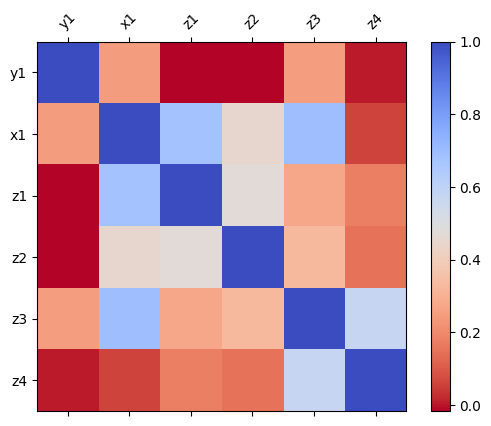

In [5]:
labels = data.columns
fig, ax = plt.subplots()
cax = ax.matshow(data.corr(), cmap='coolwarm_r')

fig.colorbar(cax)
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xticks(rotation=45)

plt.show()

## Testing RobustiPy with this simulated data

In this case we will use the simple OLSRobust class to test all possible multiple linear regressions, giving this setting. Remember, our coeficient of interest is always `y1~x1`. The variation in the plot d (the specification curve) represent the variation of this relationship depending of which covariates are included in the model.

Just to test it's functionality, we are visualizing specification `z1, z2`, `z1` and `z2`. This means that we are visualizing models `y1~x1+z1+z2`, `y1~x1+z1`, `y1~x1+z2`.

Output()

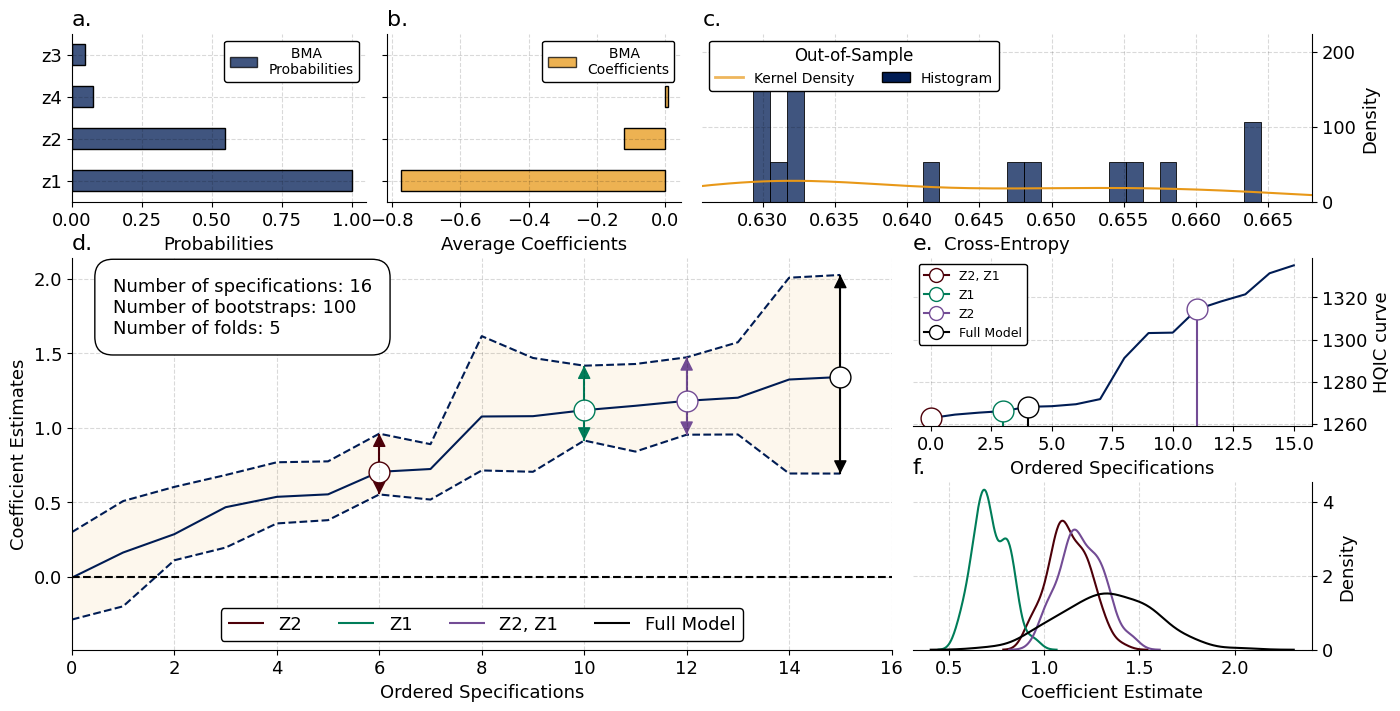

In [6]:
y = ['y1'] # input names must always be enclosed in a list.
x = ['x1']
c= ['z1', 'z2', 'z3', 'z4']

sim1 = LRobust(y=y, x=x, data=data)
sim1.fit(controls=c, draws=100, oos_metric='cross-entropy') # this time we will use cross-entropy as oos metric
sim1_results = sim1.get_results()

sim1_results.plot(specs=[['z1', 'z2'], ['z1'], ['z2']], ic='hqic', figsize=(16, 8))

Finally lets take a look at the summary of our model.

In [20]:
sim1_results.summary()

1. Model Summary
Model: Logistic Regression Robust
Dependent variable: y1
Independent variable: ['x1']
Number of possible controls: 4
Number of draws: 100
Number of folds: 5
Number of specifications: 16
2.Model Robustness Metrics
2.1 Inference Metrics
------------------------------------------------------------------------------------------------------------
Mean beta: 0.54
Significant portion of beta: 0.81
Positive portion of beta: 0.88
Positive and Significant portion of beta: 0.75
Min AIC: 3250.404164409827, Specs: ['z1', 'z4', 'z2', 'z3']
Min BIC: 1285.2572062441905, Specs: ['z1', 'z2', 'z3']
Min HQIC: 1270.0448771884405, Specs: ['z1', 'z2', 'z3']
------------------------------------------------------------------------------------------------------------
2.2 Averaged Out-Of-Sample Metrics (cross-entropy)
------------------------------------------------------------------------------------------------------------
Max: 0.6742775687078827, Specs: [] 
Min: 0.6338959832864418, Specs: ['z

It seems that ome model stands out: `y1~x1+z1+z2+z3`. Lets plot it:

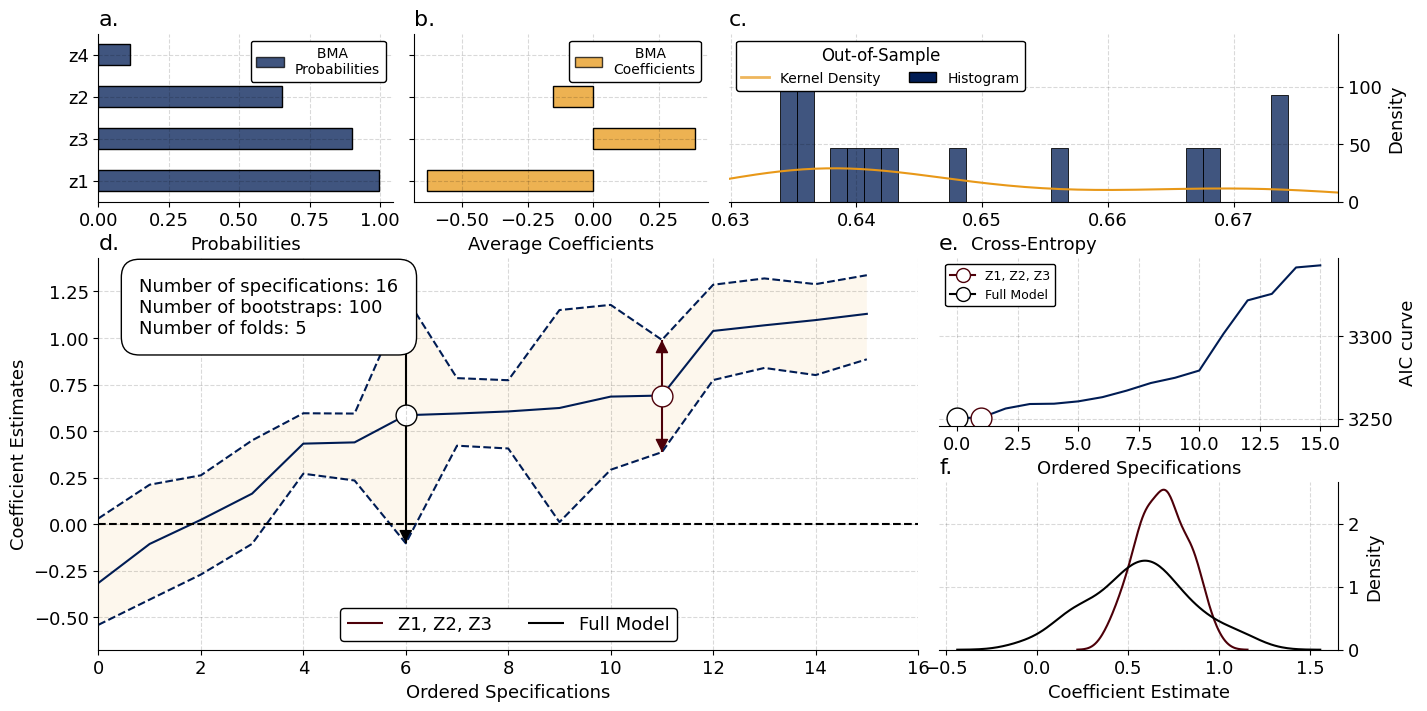

In [21]:
sim1_results.plot(specs=[['z1', 'z2', 'z3']], ic='aic', figsize=(16, 8))